In [1]:

import numpy as np
import scipy 
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = [10, 10]
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
domain=[[-1.5,1.5],[-1.5,1.5]]
D=1
beta=13
dx=0.05

#definition of the potential
VV = lambda x,y : -(x**2-x**4)  + (1+x/3)*y**2  #- 0.3*np.sin(3*x*y) +  - 0.2*np.sin(7*x*y)
VV = np.vectorize(VV)

ngrid=[ int( (domain[0][1]-domain[0][0])/dx), int((domain[1][1]-domain[1][0])/dx) ]

import scipy.sparse

def to_sequential_index(ix,iy):
    return ix*ngrid[1]+iy

def from_sequential_index(index):
    iy=index%ngrid[1]
    ix=(index-iy)/ngrid[1]
    return int(ix),int(iy)

def to_mesh(sequential,ngrid):
    z=np.zeros((ngrid[0],ngrid[1]))
    print(ngrid,z.shape)
    for iv in range(sequential.shape[0]):
        ix,iy=from_sequential_index(iv)
        z[ix,iy]=sequential[iv]
        
    return z

ngrid

[60, 60]

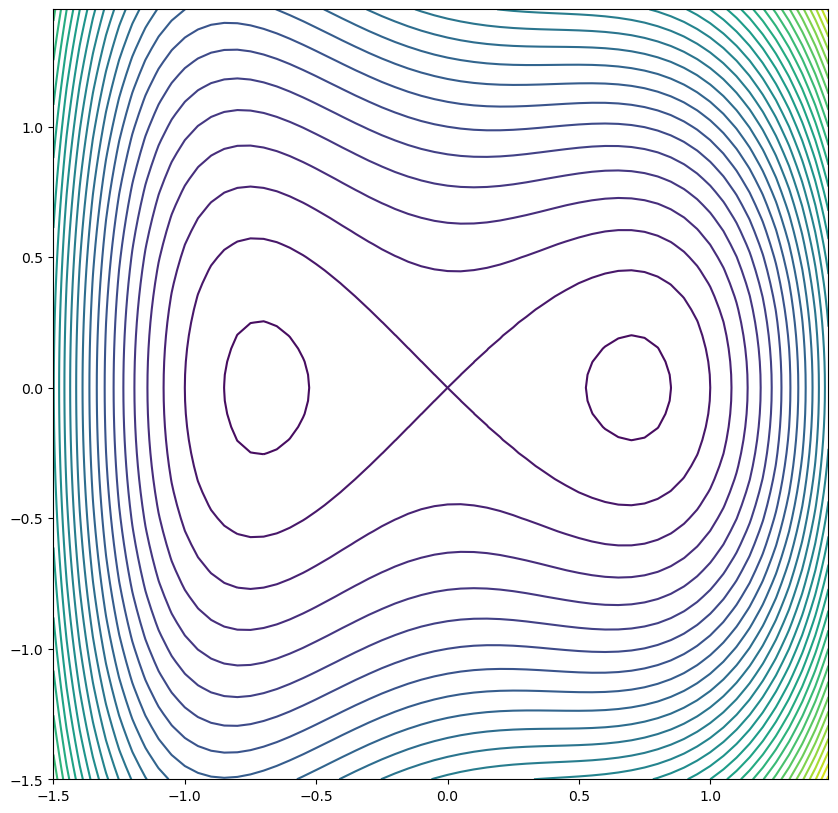

In [3]:
x = np.arange(domain[0][0], domain[0][1], dx)
y = np.arange(domain[1][0], domain[1][1], dx)
X, Y = np.meshgrid(x, y)
Z=VV(X,Y)
plt.contour(X,Y,Z,levels=30)


In [3]:

#create a base generator without the killing terms
i1=[]
i2=[]
v=[]


for iix in range(0,ngrid[0]):
    x=domain[0][0]+iix*dx
    for iiy in range(0,ngrid[1]):
        y=domain[1][0]+iiy*dx
        
        if iix+1<ngrid[0]:
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix+1,iiy))
            v.append((D/dx**2)*np.exp(-beta*(VV(x+dx,y)-VV(x,y))/2.))
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy))
            v.append(-(D/dx**2)*np.exp(-beta*(VV(x+dx,y)-VV(x,y))/2.))
        
        if iix-1>=0:
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix-1,iiy))
            v.append((D/dx**2)*np.exp(-beta*(VV(x-dx,y)-VV(x,y))/2.))
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy))
            v.append(-(D/dx**2)*np.exp(-beta*(VV(x-dx,y)-VV(x,y))/2.))

        if iiy+1<ngrid[1]:
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy+1))
            v.append((D/dx**2)*np.exp(-beta*(VV(x,y+dx)-VV(x,y))/2.))
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy))
            v.append(-(D/dx**2)*np.exp(-beta*(VV(x,y+dx)-VV(x,y))/2.))
    
        if iiy-1>=0:
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy-1))
            v.append((D/dx**2)*np.exp(-beta*(VV(x,y-dx)-VV(x,y))/2.))
            i1.append(to_sequential_index(iix,iiy))
            i2.append(to_sequential_index(iix,iiy))
            v.append(-(D/dx**2)*np.exp(-beta*(VV(x,y-dx)-VV(x,y))/2.))



Q=scipy.sparse.coo_matrix((v, (i1, i2)),shape=(ngrid[0]*ngrid[1],ngrid[0]*ngrid[1]))

#base matrix
Qref=scipy.sparse.csr_matrix(Q)
#Qref=Qref.getH()

VV_=[]
for i in range(ngrid[0]*ngrid[1]):
    ix,iy=from_sequential_index(i)
    x=domain[0][0]+ix*dx
    y=domain[1][0]+iy*dx
    VV_.append(VV(x,y))
    
    
       
print(np.max(i1),np.max(i2),ngrid[0]*ngrid[1])

3599 3599 3600


In [4]:
Qref

<3600x3600 sparse matrix of type '<class 'numpy.float64'>'
	with 17760 stored elements in Compressed Sparse Row format>

In [34]:


#add the kill term. To avoid issues with negative values, we set the kill rate to alpha**2
def add_alpha(Qref,alpha):
    
    i1=[]
    i2=[]
    v=[]
    ii=0
    mask=[]
    for i in range(ngrid[0]):
        x=domain[0][0]+i*dx
        for j in range(ngrid[1]):
            y=domain[1][0]+j*dx
            
            iseq=to_sequential_index(i,j)
            i1.append(iseq)
            i2.append(iseq)
                        
            # v.append(-alpha[ii]**2)
            # mask.append(1)
                
            #can use this to impose specific values of alpha in different regions

            #initial well
        if np.sqrt((x+0.7)**2 + (y)**2) < 0.2:
            #v.append(-np.exp(-6))
            v.append(0)
            mask.append(0.)
        elif np.sqrt((x-0.7)**2 + (y)**2) < 0.2: #kill zone
            #v.append(-np.exp(3))
            v.append(-10000)
            mask.append(0.)
        elif x>1.2: #kill zone
            v.append(-10000)
            #v.append(-np.exp(3))
            mask.append(0.)
        else:
            v.append(-alpha[ii]**2)
            #v.append(-np.exp(alpha[ii]))
            mask.append(1)
        
        ii+=1
        
            
    print(len(i1),len(i2),len(v))
    Qa=scipy.sparse.coo_matrix((v, (i1, i2)),shape=(ngrid[0]*ngrid[1],ngrid[0]*ngrid[1]))
    Qa=scipy.sparse.csr_matrix(Qa)
    
    Q=Qref+Qa
    
    mask=np.array(mask)
    alpha=np.array(v)
    return Q,mask
    
    

#initialize a "clean" alpha field
def clean_alpha(alpha):
    
    i1=[]
    i2=[]
    v=[]
    ii=0
    mask=[]
    for i in range(ngrid[0]):
        x=domain[0][0]+i*dx
        for j in range(ngrid[1]):
            y=domain[1][0]+j*dx
            
            iseq=to_sequential_index(i,j)
            i1.append(iseq)
            i2.append(iseq)
            
            gmax=np.sqrt(200)
            gmin=np.sqrt(0.0000001)
            
            #alpha[ii]=(np.tanh( 1*(x-0.4) ) +1.)*0.5*(gmax-gmin)+gmin
        
            if x<-0.5:
                alpha[ii]=1e-1
            else:
                alpha[ii]=np.sqrt(100)
            

            #initial well
            if np.sqrt((x+0.7)**2 + (y)**2) < 0.2:
                alpha[ii]=0
            elif np.sqrt((x-0.7)**2 + (y)**2) < 0.2:
                alpha[ii]=np.sqrt(100)
                #alpha[ii]=3
            elif x>1.2:
                alpha[ii]=np.sqrt(100)
                #alpha[ii]=3
            else:
                pass

            ii+=1
        
    return alpha
    
    
    
#compute the objective function
def compute_obj(alpha):
    Q,mask=add_alpha(Qref,alpha)
    w,v=scipy.sparse.linalg.eigs(Q,k=2,which='SM',tol=1e-15)
    w=w.real 
    
    grads=np.zeros(v.shape)
    
    for iw in range(v.shape[1]):
        for iseq in range(v.shape[0]):
            grads[iseq,iw]=-2*alpha[iseq]*v[iseq,iw]**2
            #grads[iseq,iw]=-np.exp(alpha[iseq])*v[iseq,iw]**2

    isort=np.argsort(w)
    l1=w[isort[-1]]
    l2=w[isort[-2]]
    
    #print("w* ",w[isort])
    
    obj=(l2-l1)/l1
    
    print('obj: ',obj,w[isort],flush=True)
    
    gr=np.zeros(alpha.shape)
    
    gr=(1./l1)*(grads[:,isort[-2]]-grads[:,isort[-1]])-(1./l1**2)*(l2-l1)*grads[:,isort[-1]]
    
    #mask out the gradient in the fixed regions
    gr=np.multiply(gr,mask)
    #setup for minimization
    obj*=-1
    gr*=-1
    
    return obj, gr

#compute the gradient of the objective function using eigenvalue perturbation
def compute_obj_grad(alpha):
    Q,mask=add_alpha(Qref,alpha)
    w,v=scipy.sparse.linalg.eigs(Q,k=2,which='SM',tol=1e-15)
    w=w.real 
    
    grads=np.zeros(v.shape)
    
    for iw in range(v.shape[1]):
        for iseq in range(v.shape[0]):
            grads[iseq,iw]=-2*alpha[iseq]*v[iseq,iw]**2
            #grads[iseq,iw]=-np.exp(alpha[iseq])*v[iseq,iw]**2

    isort=np.argsort(w)
    l1=w[isort[-1]]
    l2=w[isort[-2]]
    
    #print("w* ",w[isort])
    
    obj=(l2-l1)/l1
    gr=np.zeros(alpha.shape)
    
    gr=(1./l1)*(grads[:,isort[-2]]-grads[:,isort[-1]])-(1./l1**2)*(l2-l1)*grads[:,isort[-1]]
    
    return l1,l2,v[:,isort[-1]],v[:,isort[-2]],grads[:,isort[-1]],grads[:,isort[-2]],gr




    

10.0 0.0
[60, 60] (60, 60)
[60, 60] (60, 60)


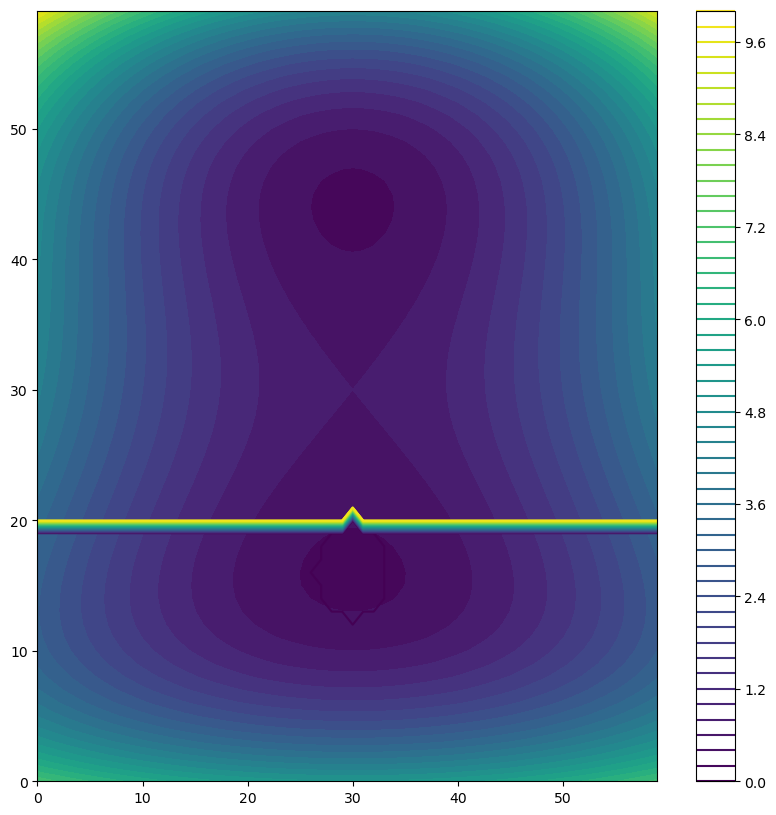

In [39]:
#initialize alpha
alpha=1e0*np.ones((ngrid[0]*ngrid[1]))
alpha=clean_alpha(alpha)


print(np.max(alpha),np.min(alpha))

z=to_mesh(np.array(VV_),ngrid)
plt.contourf(z,levels=30)

z=to_mesh(alpha,ngrid)
plt.contour(z,levels=50)
plt.colorbar()
plt.show()


In [38]:
alpha=np.sqrt(1000)*np.ones((ngrid[0]*ngrid[1]))
alpha=clean_alpha(alpha)

#alpha=clean_alpha_rad(alpha,np.array([-0.75,-0.25]),1.7)

from scipy.optimize import minimize
#'L-BFGS-B'
#res = minimize(compute_obj, alpha, jac=True, method='L-BFGS-B',tol=1e-15,options={'gtol': 1e-15, 'disp': True,'maxiter':10})




[60, 60] (60, 60)
0.0 10.0
[60, 60] (60, 60)


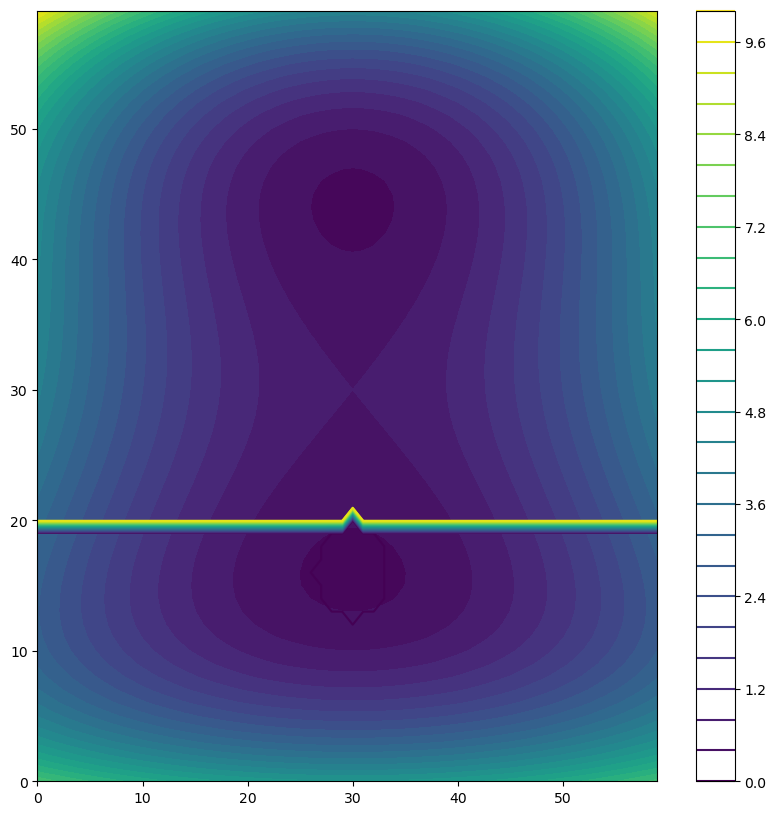

In [10]:

z=to_mesh(np.array(VV_),ngrid)
plt.contourf(z,levels=30)


print(np.min(alpha),np.max(alpha))
z=to_mesh(alpha,ngrid)
plt.contour(z,levels=30)
plt.colorbar()
plt.show()

/tmp/ipykernel_79489/3271180005.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


[60, 60] (60, 60)
[60, 60] (60, 60)


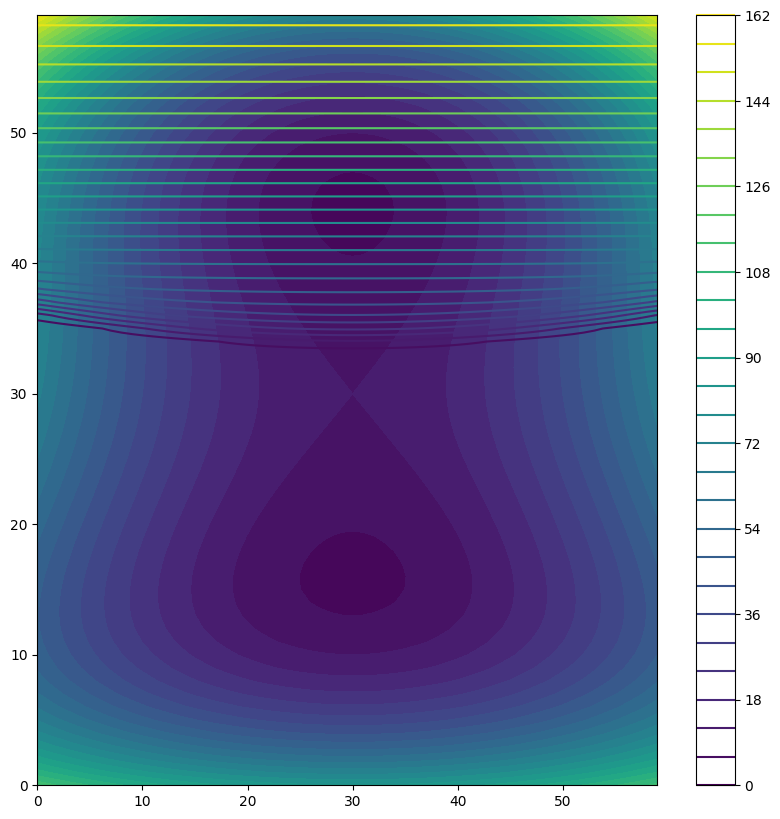

obj:  106.22576789114136 [-20.14020616  -0.18782991]


/tmp/ipykernel_79489/3271180005.py:18: OptimizeWarning: Unknown solver options: eta
  res = minimize(compute_obj, res.x, jac=True, method='L-BFGS-B',tol=1e-15,options={'gtol': 1e-15, 'disp': True,'maxiter':100,'eta':0.8})
/tmp/ipykernel_79489/238267159.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  grads[iseq,iw]=-2*alpha[iseq]*v[iseq,iw]**2
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.06226D+02    |proj g|=  7.22889D-02
obj:  106.4842843384059 [-20.13989553  -0.18737526]

At iterate    1    f= -1.06484D+02    |proj g|=  6.73838D-02
obj:  106.92178533436619 [-20.1395997   -0.18661292]

At iterate    2    f= -1.06922D+02    |proj g|=  4.85971D-02
obj:  107.14478267296644 [-20.13956032  -0.18622776]

At iterate    3    f= -1.07145D+02    |proj g|=  4.87502D-02
obj:  106.95315440676028 [-20.14052812  -0.1865673 ]
obj:  107.59381021746049 [-20.13918543  -0.18545427]

At iterate    4    f= -1.07594D+02    |proj g|=  7.01329D-02
obj:  108.29370387605965 [-20.13881282  -0.18426325]

At iterate    5    f= -1.08294D+02    |proj g|=  8.34351D-02
obj:  108.56795476226779 [-20.13871788  -0.18380117]

At iterate    6    f= -1.08568D+02    |proj g|=  6.24297D-02
obj:  108.87355898320268 [-20

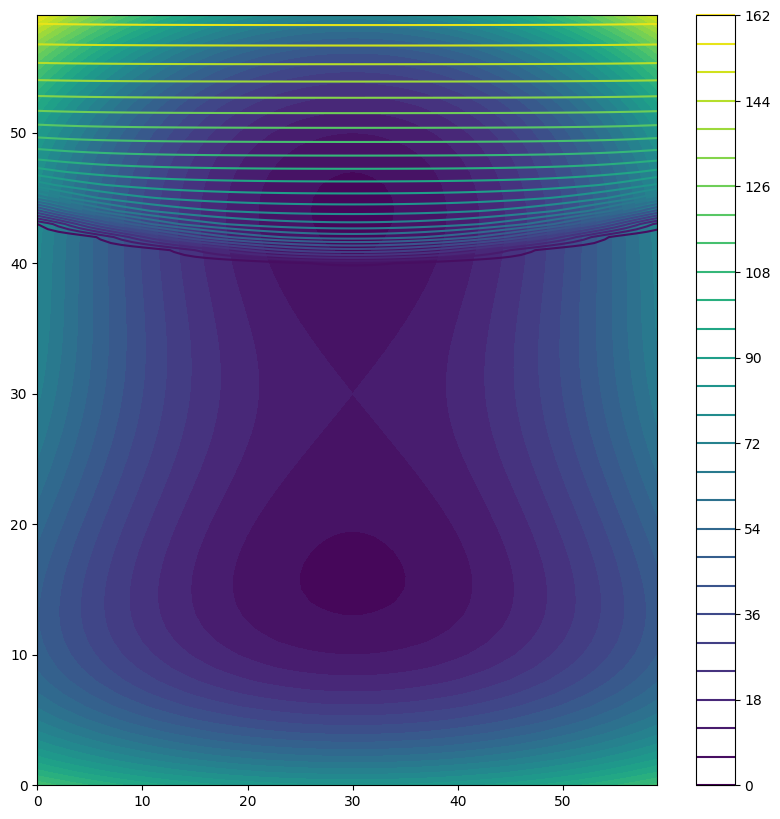

obj:  113.56325459646598 [-20.13623083  -0.17576518]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13563D+02    |proj g|=  4.95456D-03


 This problem is unconstrained.


obj:  113.51576208236759 [-20.13631732  -0.17583883]
obj:  113.5609387571542 [-20.13623738  -0.17576879]
obj:  113.56402243899304 [-20.13623073  -0.175764  ]

At iterate    1    f= -1.13564D+02    |proj g|=  5.45382D-03
obj:  113.56515183757415 [-20.13623009  -0.17576226]

At iterate    2    f= -1.13565D+02    |proj g|=  4.68024D-03
obj:  113.57007684199156 [-20.13623019  -0.17575471]

At iterate    3    f= -1.13570D+02    |proj g|=  9.72451D-03
obj:  113.57299611154828 [-20.13622975  -0.17575022]

At iterate    4    f= -1.13573D+02    |proj g|=  7.22299D-03
obj:  113.57503220853602 [-20.13622692  -0.17574708]

At iterate    5    f= -1.13575D+02    |proj g|=  5.00949D-03
obj:  113.57756360543732 [-20.13622576  -0.17574318]

At iterate    6    f= -1.13578D+02    |proj g|=  2.71852D-03
obj:  113.58115628534446 [-20.13622479  -0.17573766]

At iterate    7    f= -1.13581D+02    |proj g|=  3.13235D-03
obj:  113.58798029249232 [-20.13622271  -0.17572718]

At iterate    8    f= -1.13588D+02  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


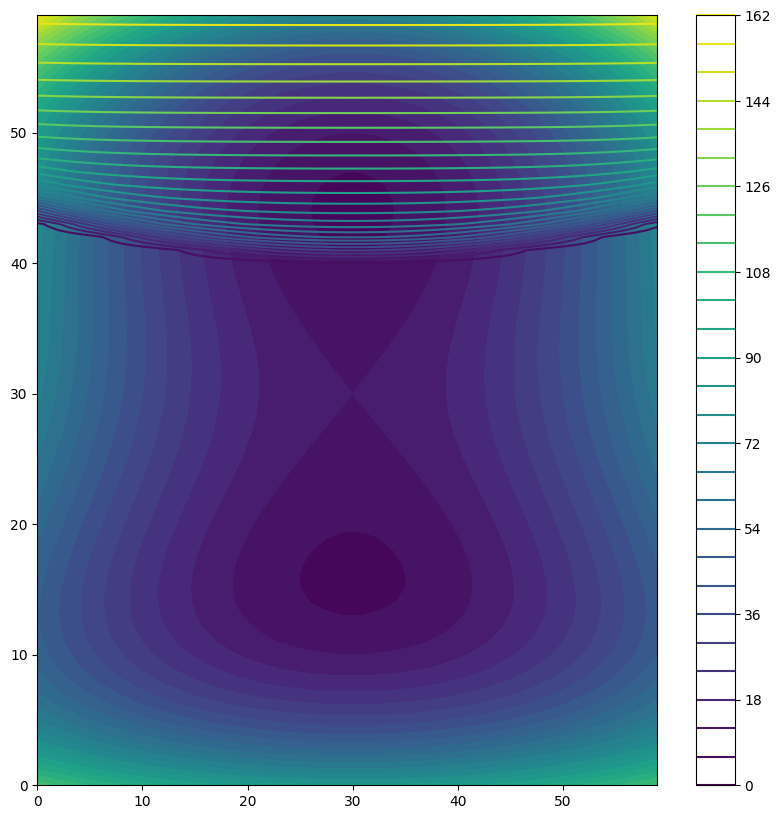

obj:  113.63381909403338 [-20.13620805  -0.17565678]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13634D+02    |proj g|=  3.42083D-03


 This problem is unconstrained.


obj:  113.42384107506267 [-20.12878126  -0.17591422]
obj:  113.63427141742702 [-20.13620766  -0.17565609]

At iterate    1    f= -1.13634D+02    |proj g|=  2.21788D-03
obj:  113.6347694197618 [-20.13620765  -0.17565532]

At iterate    2    f= -1.13635D+02    |proj g|=  2.69143D-03
obj:  113.62935721768623 [-20.13495017  -0.17565265]
obj:  113.63492318963165 [-20.13620763  -0.17565509]
obj:  113.63597977778649 [-20.13620217  -0.17565342]
obj:  113.63548406163983 [-20.13620757  -0.17565423]

At iterate    3    f= -1.13635D+02    |proj g|=  3.66749D-03
obj:  113.5937681277698 [-20.1280355   -0.17564686]
obj:  113.63559744934534 [-20.13620754  -0.17565406]
obj:  113.60987913127109 [-20.13113825  -0.17564924]
obj:  113.63567228560578 [-20.13620752  -0.17565394]
obj:  113.62028952765331 [-20.13314686  -0.17565081]
obj:  113.63572346293185 [-20.1362075   -0.17565386]
obj:  113.62700082139139 [-20.1344433   -0.17565184]
obj:  113.63576036275992 [-20.13620749  -0.1756538 ]
obj:  113.63131180774


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


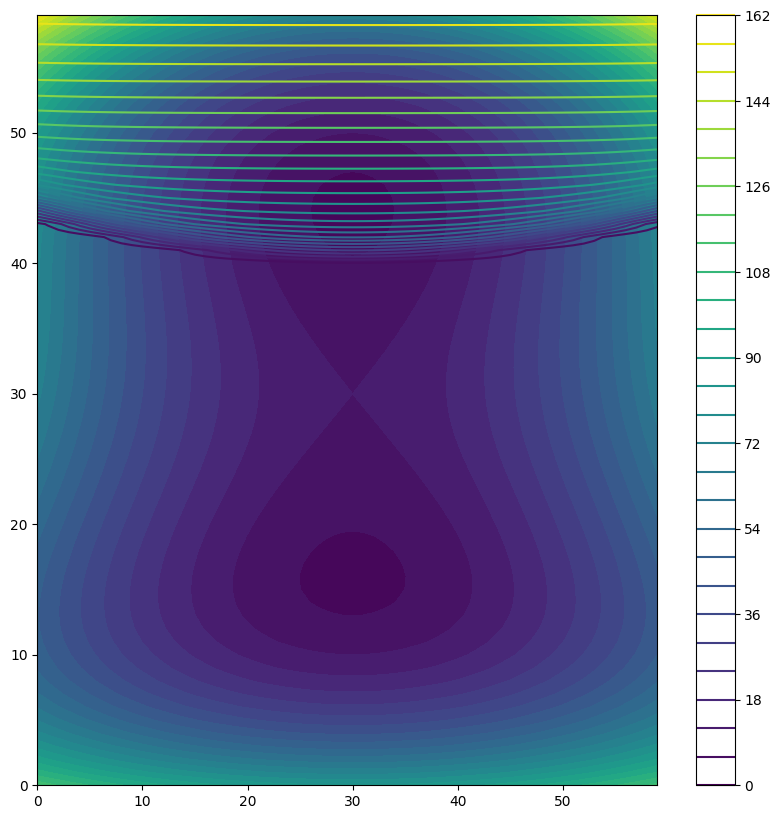

obj:  113.63719639297014 [-20.13619764  -0.17565152]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13637D+02    |proj g|=  2.08693D-03


 This problem is unconstrained.


obj:  113.35633624140719 [-20.11869115  -0.17592983]
obj:  113.63636620809505 [-20.13601841  -0.17565123]
obj:  113.63719810101581 [-20.13619648  -0.17565151]
obj:  113.63675543498856 [-20.13609625  -0.17565131]
obj:  113.63719832173818 [-20.13619549  -0.1756515 ]
obj:  113.63698249671727 [-20.13614286  -0.17565137]
obj:  113.63719780996658 [-20.13619462  -0.17565149]
obj:  113.63719827733811 [-20.13619534  -0.1756515 ]
obj:  113.63719832409629 [-20.13619549  -0.1756515 ]

At iterate    1    f= -1.13637D+02    |proj g|=  2.00688D-03
obj:  113.63607986829092 [-20.13596104  -0.17565117]
obj:  113.63719741563301 [-20.13619331  -0.17565148]
obj:  113.63719843074611 [-20.13619511  -0.17565149]
obj:  113.63719804694534 [-20.13619397  -0.17565148]
obj:  113.63719843746205 [-20.1361949   -0.17565149]
obj:  113.63719825651977 [-20.1361943   -0.17565149]
obj:  113.6371984253883 [-20.13619479  -0.17565149]
obj:  113.63719843617652 [-20.13619488  -0.17565149]
obj:  113.63719843594171 [-20.1361949 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


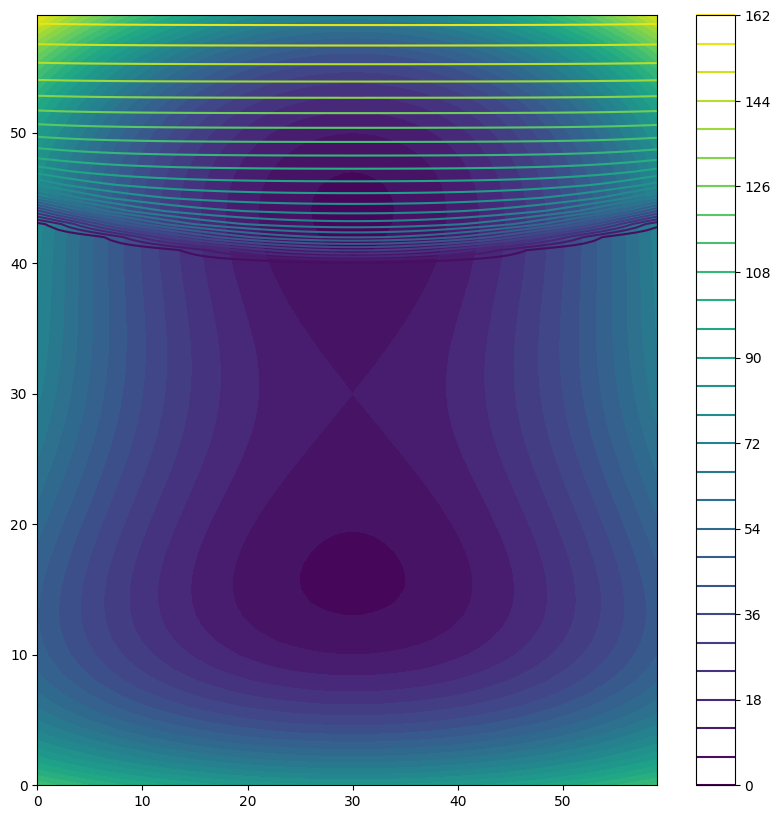

obj:  113.63720522446256 [-20.13618073  -0.17565136]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13637D+02    |proj g|=  8.77214D-04


 This problem is unconstrained.


obj:  113.40837487230786 [-20.12118568  -0.17587162]
obj:  113.63670146793191 [-20.13607914  -0.17565124]
obj:  113.63720053035597 [-20.13617966  -0.17565136]
obj:  113.63720510341605 [-20.1361807   -0.17565136]
obj:  113.63720522203681 [-20.13618073  -0.17565136]
obj:  113.63720522592591 [-20.13618073  -0.17565136]
obj:  113.63720522791073 [-20.13618073  -0.17565136]
obj:  113.63720522435312 [-20.13618073  -0.17565136]
obj:  113.63720522672848 [-20.13618073  -0.17565136]
obj:  113.63720522476713 [-20.13618073  -0.17565136]
obj:  113.63720522446312 [-20.13618073  -0.17565136]

At iterate    1    f= -1.13637D+02    |proj g|=  8.77214D-04
obj:  113.63707528684674 [-20.13615169  -0.1756513 ]
obj:  113.63720186061894 [-20.13617984  -0.17565136]
obj:  113.63720504725889 [-20.13618068  -0.17565136]
obj:  113.63720521550586 [-20.13618073  -0.17565136]
obj:  113.6372052233355 [-20.13618073  -0.17565136]
obj:  113.63720522408052 [-20.13618073  -0.17565136]
obj:  113.63720522565102 [-20.13618073


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


obj:  113.63914226001442 [-20.1362056   -0.17564861]

At iterate   16    f= -1.13639D+02    |proj g|=  1.46189D-03
obj:  113.63741747076648 [-20.13583832  -0.17564805]
obj:  113.63915669704829 [-20.13620559  -0.17564858]
obj:  113.63867724884916 [-20.13607978  -0.17564822]
obj:  113.63917612758915 [-20.13620558  -0.17564855]
obj:  113.63924405362292 [-20.13620553  -0.17564845]

At iterate   17    f= -1.13639D+02    |proj g|=  1.01673D-03
obj:  113.62873370604464 [-20.13417529  -0.17564684]
obj:  113.63926053695738 [-20.13620551  -0.17564842]
obj:  113.63926987420064 [-20.1362055   -0.17564841]
obj:  113.63436358469613 [-20.13525134  -0.1756476 ]
obj:  113.63927805024716 [-20.13620548  -0.1756484 ]
obj:  113.63928258136794 [-20.13620547  -0.17564839]
obj:  113.63710094557177 [-20.13577659  -0.17564799]
obj:  113.63928688702754 [-20.13620546  -0.17564838]
obj:  113.63928926692161 [-20.13620545  -0.17564838]
obj:  113.63843167717822 [-20.13603243  -0.17564818]
obj:  113.63929183517533 [-2

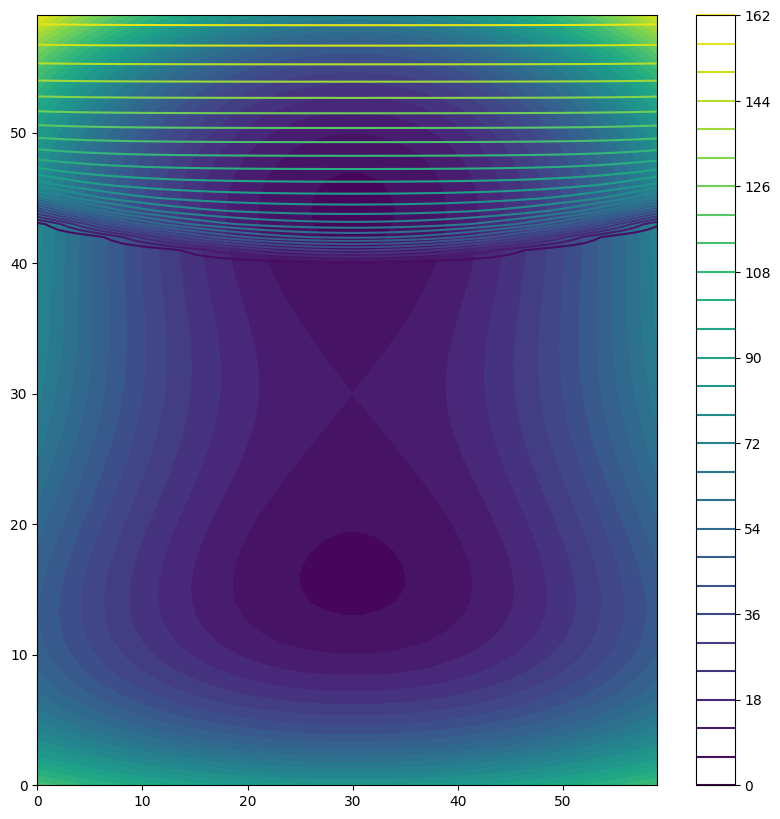

obj:  113.63932125915487 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71785D-04


 This problem is unconstrained.


obj:  113.50332898754402 [-20.11039993  -0.17563157]
obj:  113.6376917637457 [-20.13588999  -0.17564808]
obj:  113.63931984330145 [-20.13620392  -0.17564832]
obj:  113.63932121915177 [-20.13620447  -0.17564832]
obj:  113.63932125330624 [-20.13620451  -0.17564832]
obj:  113.63932125827132 [-20.13620451  -0.17564832]
obj:  113.63932125565385 [-20.13620451  -0.17564832]
obj:  113.63932125474848 [-20.13620451  -0.17564832]
obj:  113.63932125553356 [-20.13620451  -0.17564832]
obj:  113.63932125728003 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


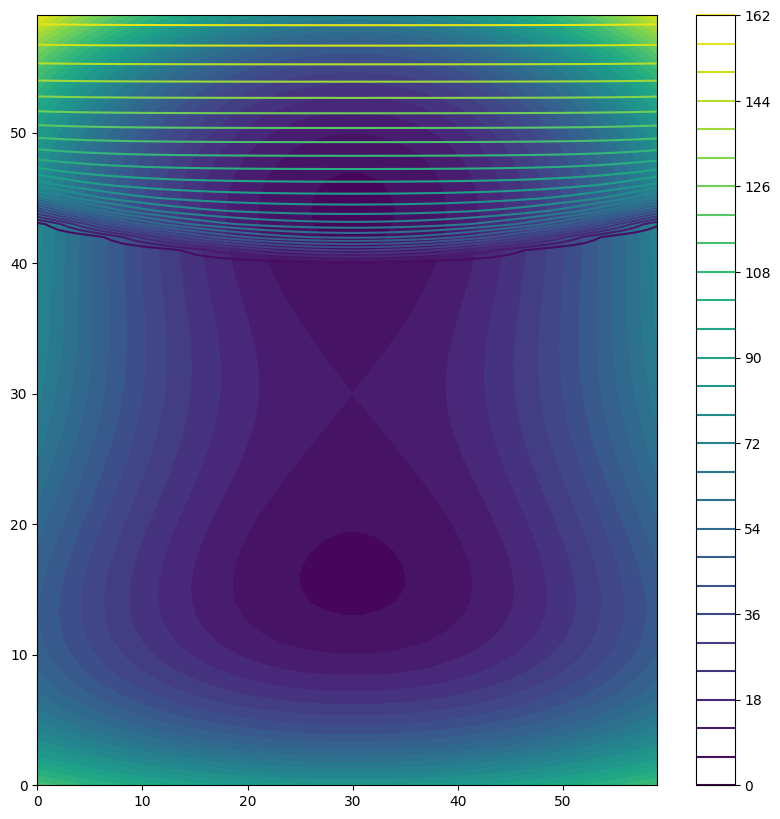

obj:  113.63932125630967 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71785D-04


 This problem is unconstrained.


obj:  113.50332898359842 [-20.11039993  -0.17563157]
obj:  113.63769176145139 [-20.13588999  -0.17564808]
obj:  113.63931984542212 [-20.13620392  -0.17564832]
obj:  113.63932122049191 [-20.13620447  -0.17564832]
obj:  113.63932125325513 [-20.13620451  -0.17564832]
obj:  113.63932125633998 [-20.13620451  -0.17564832]
obj:  113.63932125422927 [-20.13620451  -0.17564832]
obj:  113.63932125726028 [-20.13620451  -0.17564832]
obj:  113.63932125495563 [-20.13620451  -0.17564832]
obj:  113.63932125487706 [-20.13620451  -0.17564832]
obj:  113.63932125493969 [-20.13620451  -0.17564832]
obj:  113.63932125646951 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71588D-04
obj:  113.63902960585486 [-20.13614731  -0.17564827]
obj:  113.6393211299189 [-20.13620439  -0.17564832]
obj:  113.63932124335238 [-20.13620449  -0.17564832]
obj:  113.63932125322593 [-20.13620451  -0.17564832]
obj:  113.63932125593453 [-20.13620451  -0.17564832]
obj:  113.63932125426554 [-20.13620451


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


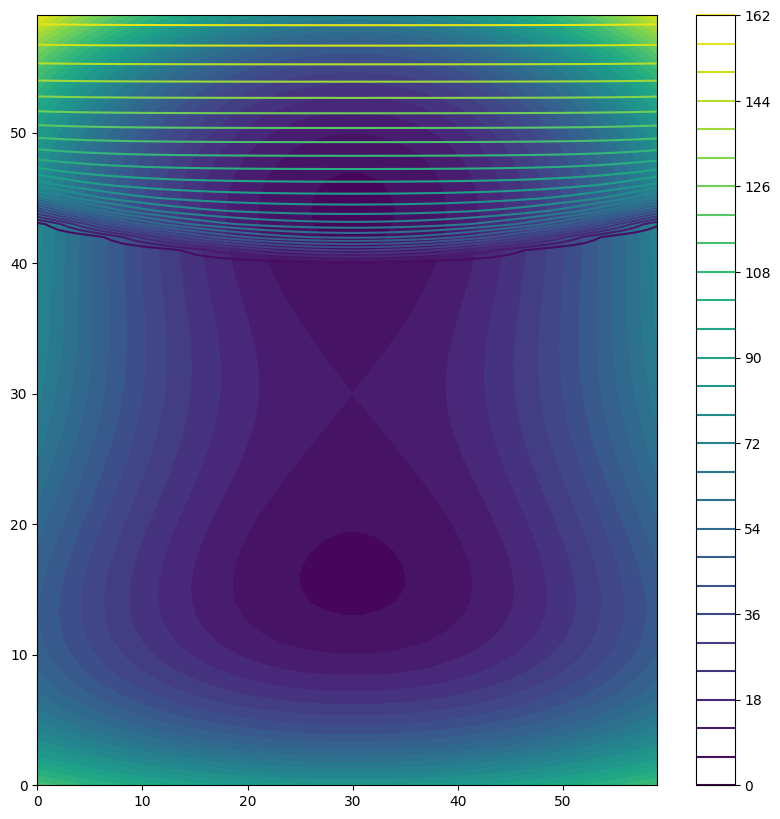

obj:  113.63932125650561 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71588D-04


 This problem is unconstrained.


obj:  113.50333345889055 [-20.11040091  -0.17563158]
obj:  113.6376920283368 [-20.13589005  -0.17564808]
obj:  113.63931983511769 [-20.13620392  -0.17564832]
obj:  113.63932121954767 [-20.13620447  -0.17564832]
obj:  113.63932125308621 [-20.1362045   -0.17564832]
obj:  113.63932125309896 [-20.13620451  -0.17564832]
obj:  113.63932125583548 [-20.13620451  -0.17564832]
obj:  113.63932125601073 [-20.13620451  -0.17564832]
obj:  113.63932125624397 [-20.13620451  -0.17564832]
obj:  113.63932125445498 [-20.13620451  -0.17564832]
obj:  113.63932125701204 [-20.13620451  -0.17564832]
obj:  113.63932125543313 [-20.13620451  -0.17564832]
obj:  113.63932125563308 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71588D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final genera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


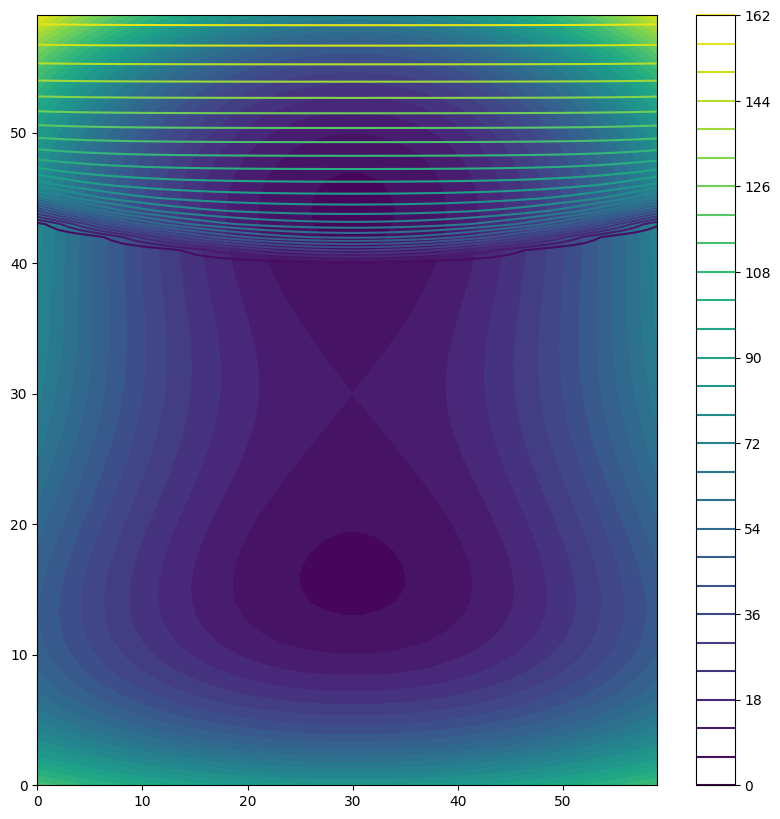

obj:  113.63932125480825 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71588D-04


 This problem is unconstrained.


obj:  113.50333345183907 [-20.11040091  -0.17563158]
obj:  113.63769202694128 [-20.13589005  -0.17564808]
obj:  113.63931983478759 [-20.13620392  -0.17564832]
obj:  113.63932121786213 [-20.13620447  -0.17564832]
obj:  113.63932124988932 [-20.1362045   -0.17564832]
obj:  113.63932125445463 [-20.13620451  -0.17564832]
obj:  113.63932125562988 [-20.13620451  -0.17564832]
obj:  113.63932125582225 [-20.13620451  -0.17564832]
obj:  113.63932125498305 [-20.13620451  -0.17564832]
obj:  113.63932125542762 [-20.13620451  -0.17564832]
obj:  113.6393212551599 [-20.13620451  -0.17564832]
obj:  113.63932125538545 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71557D-04
obj:  113.63903196311728 [-20.13614776  -0.17564827]
obj:  113.63932113085625 [-20.1362044   -0.17564832]
obj:  113.63932124335183 [-20.13620449  -0.17564832]
obj:  113.6393212529085 [-20.13620451  -0.17564832]
obj:  113.63932125756499 [-20.13620451  -0.17564832]
obj:  113.63932125575509 [-20.13620451 

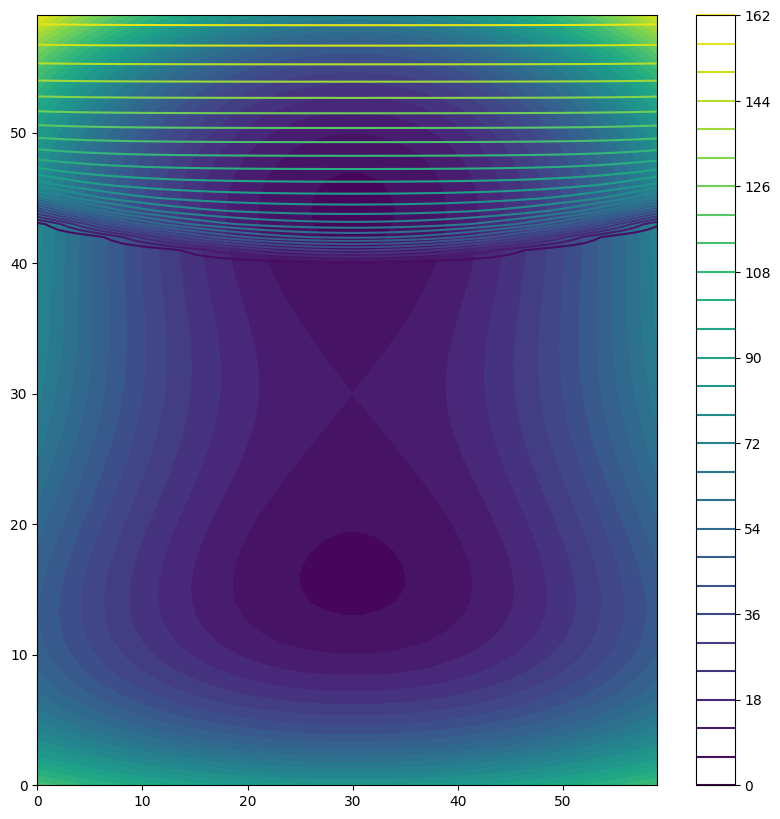

obj:  113.63932125564078 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71502D-04


 This problem is unconstrained.


obj:  113.50333538198443 [-20.11040132  -0.17563158]
obj:  113.63769214834159 [-20.13589007  -0.17564808]
obj:  113.63931982770954 [-20.13620391  -0.17564832]
obj:  113.63932121744315 [-20.13620447  -0.17564832]
obj:  113.63932125147271 [-20.1362045   -0.17564832]
obj:  113.63932125336407 [-20.13620451  -0.17564832]
obj:  113.63932125295848 [-20.13620451  -0.17564832]
obj:  113.63932125539908 [-20.13620451  -0.17564832]
obj:  113.63932125581155 [-20.13620451  -0.17564832]
obj:  113.63932125448747 [-20.13620451  -0.17564832]
obj:  113.6393212549965 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71502D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


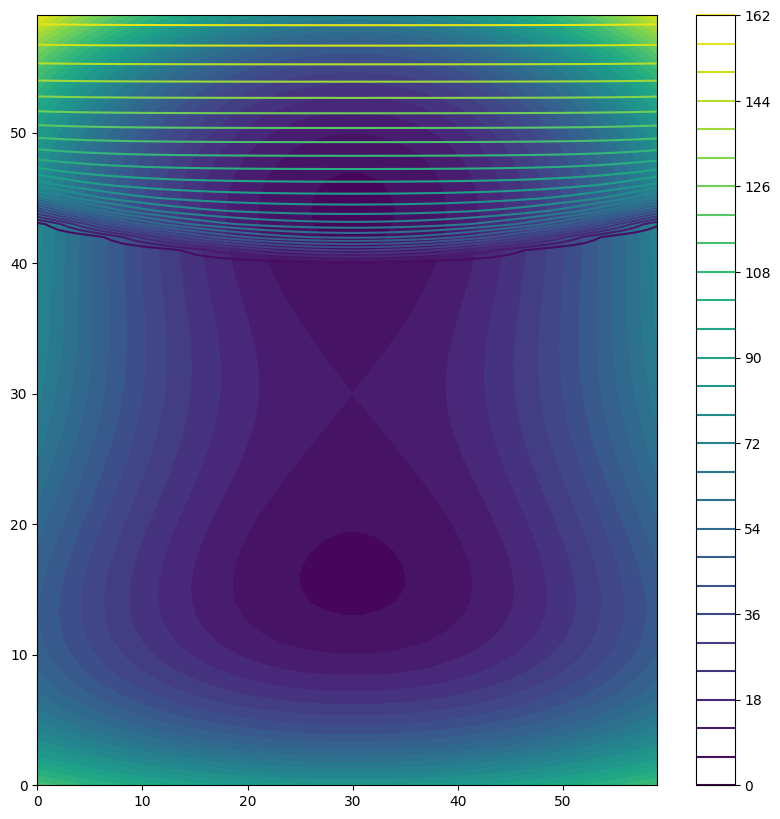

obj:  113.63932125657641 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71502D-04


 This problem is unconstrained.


obj:  113.50333537833461 [-20.11040132  -0.17563158]
obj:  113.63769214559504 [-20.13589007  -0.17564808]
obj:  113.63931982925007 [-20.13620391  -0.17564832]
obj:  113.6393212183336 [-20.13620447  -0.17564832]
obj:  113.63932125061511 [-20.1362045   -0.17564832]
obj:  113.63932125315677 [-20.13620451  -0.17564832]
obj:  113.63932125803369 [-20.13620451  -0.17564832]
obj:  113.63932125647129 [-20.13620451  -0.17564832]
obj:  113.63932125433213 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 3600      1     10      1     0     0   9

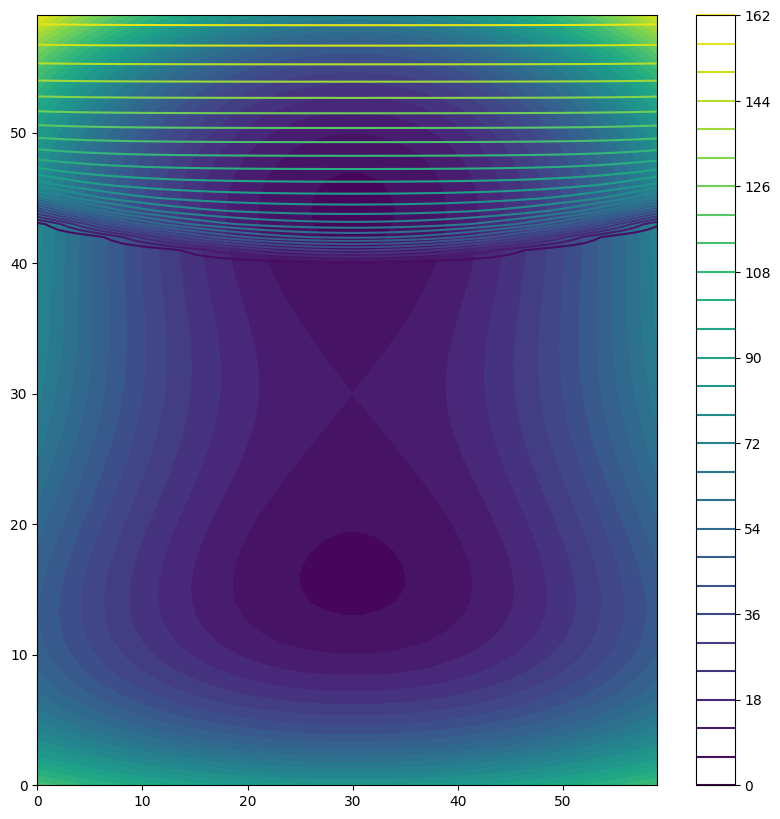

obj:  113.63932125568803 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71492D-04


 This problem is unconstrained.


obj:  113.50333560354343 [-20.11040137  -0.17563158]
obj:  113.63769215884852 [-20.13589007  -0.17564808]
obj:  113.63931982921535 [-20.13620391  -0.17564832]
obj:  113.63932121779253 [-20.13620447  -0.17564832]
obj:  113.63932125009951 [-20.1362045   -0.17564832]
obj:  113.6393212537624 [-20.13620451  -0.17564832]
obj:  113.63932125537495 [-20.13620451  -0.17564832]
obj:  113.63932125659403 [-20.13620451  -0.17564832]
obj:  113.63932125439221 [-20.13620451  -0.17564832]
obj:  113.63932125628503 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.71491D-04
obj:  113.63900813564159 [-20.13614316  -0.17564827]
obj:  113.63932112102155 [-20.13620439  -0.17564832]
obj:  113.63932124564894 [-20.13620449  -0.17564832]
obj:  113.63932125498684 [-20.13620451  -0.17564832]
obj:  113.63932125487179 [-20.13620451  -0.17564832]
obj:  113.63932125590576 [-20.13620451  -0.17564832]
obj:  113.63932125434377 [-20.13620451  -0.17564832]
obj:  113.63932125537902 [-20.13620451


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


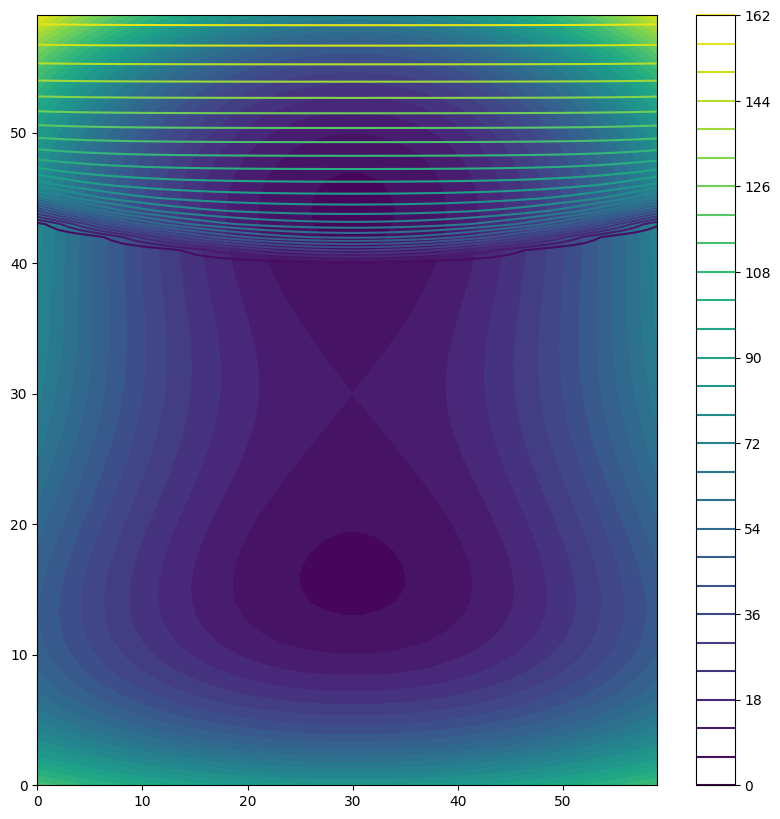

obj:  113.63932125354057 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.71491D-04


 This problem is unconstrained.


obj:  113.50333563347222 [-20.11040138  -0.17563158]
obj:  113.63769215971969 [-20.13589007  -0.17564808]
obj:  113.63931983002063 [-20.13620391  -0.17564832]
obj:  113.63932121731902 [-20.13620447  -0.17564832]
obj:  113.63932125033135 [-20.1362045   -0.17564832]
obj:  113.63932125413467 [-20.13620451  -0.17564832]
obj:  113.63932125441399 [-20.13620451  -0.17564832]
obj:  113.6393212496043 [-20.1362045   -0.17564832]
obj:  113.6393212528887 [-20.13620451  -0.17564832]
obj:  113.63932125108501 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg

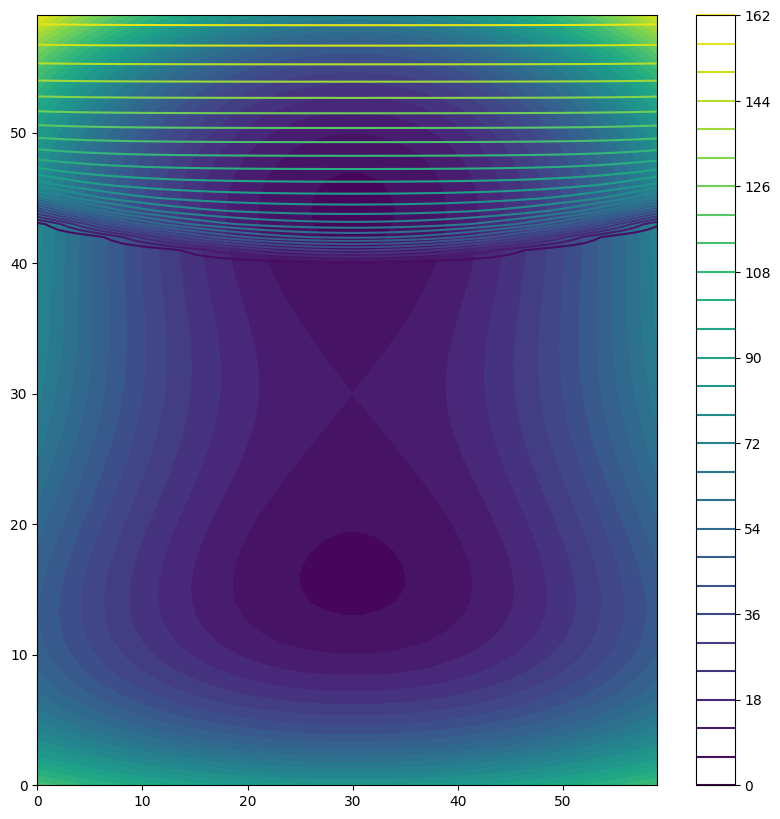

obj:  113.6393212523625 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70965D-04


 This problem is unconstrained.


obj:  113.5033475382728 [-20.11040399  -0.17563158]
obj:  113.63769286554403 [-20.13589021  -0.17564808]
obj:  113.63931980129735 [-20.13620391  -0.17564832]
obj:  113.63932121236999 [-20.13620447  -0.17564832]
obj:  113.63932124816645 [-20.1362045   -0.17564832]
obj:  113.63932125224777 [-20.1362045   -0.17564832]
obj:  113.63932125014254 [-20.13620451  -0.17564832]
obj:  113.63932125054542 [-20.13620451  -0.17564832]
obj:  113.63932125197155 [-20.13620451  -0.17564832]
obj:  113.63932125218271 [-20.13620451  -0.17564832]
obj:  113.6393212520664 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


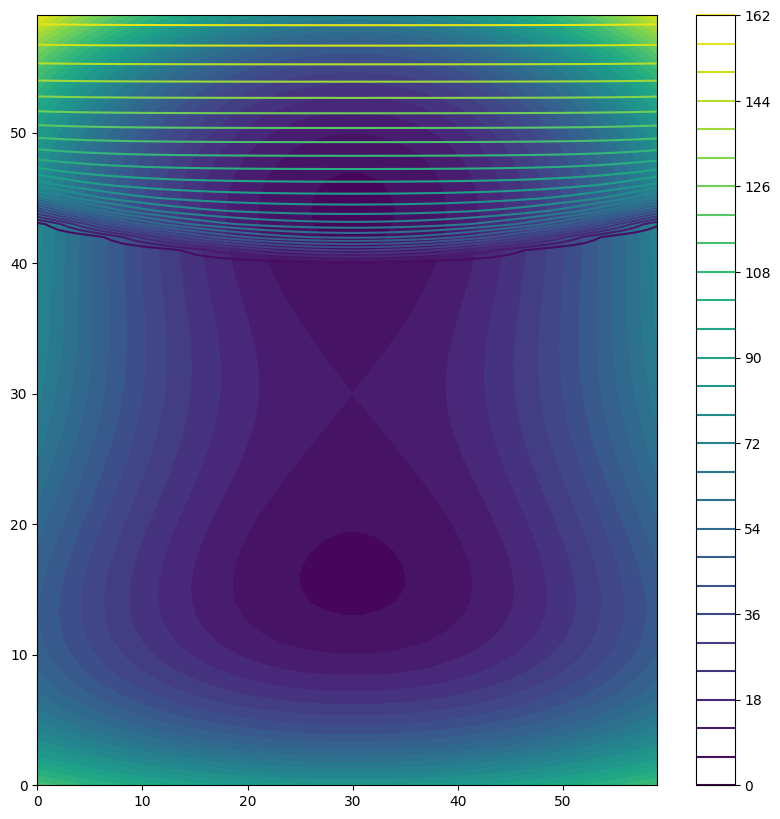

obj:  113.63932125305344 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70965D-04


 This problem is unconstrained.


obj:  113.503347538186 [-20.11040399  -0.17563158]
obj:  113.63769286705295 [-20.13589021  -0.17564808]
obj:  113.63931980134855 [-20.13620391  -0.17564832]
obj:  113.63932121186907 [-20.13620447  -0.17564832]
obj:  113.63932124649375 [-20.1362045   -0.17564832]
obj:  113.63932125091107 [-20.1362045   -0.17564832]
obj:  113.6393212526705 [-20.13620451  -0.17564832]
obj:  113.63932125010672 [-20.13620451  -0.17564832]
obj:  113.63932125102995 [-20.13620451  -0.17564832]
obj:  113.63932125140293 [-20.13620451  -0.17564832]
obj:  113.6393212512055 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


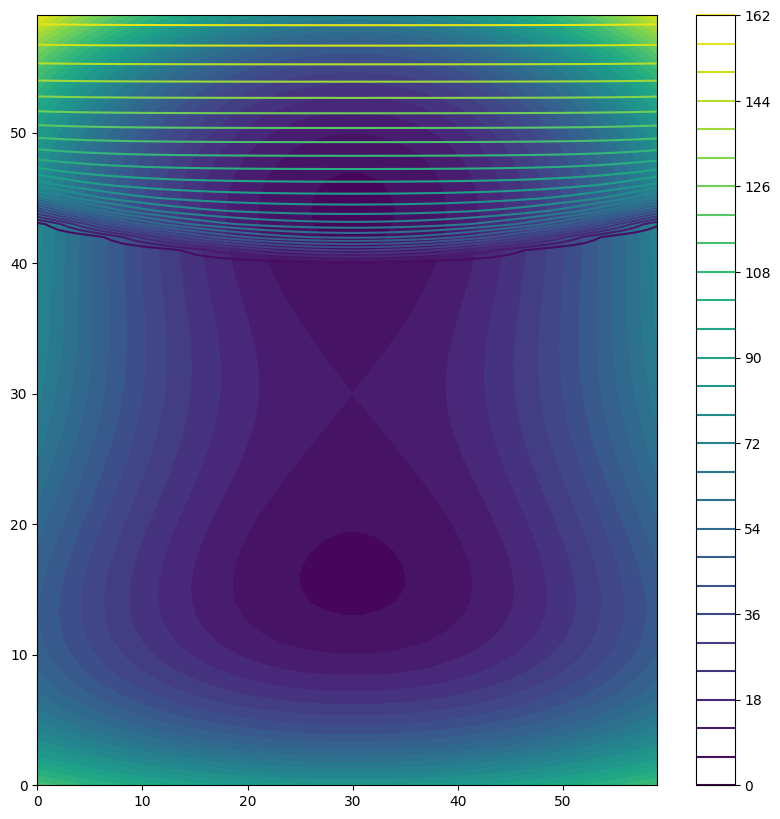

obj:  113.63932125223106 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70965D-04


 This problem is unconstrained.


obj:  113.50334753609663 [-20.11040399  -0.17563158]
obj:  113.6376928661404 [-20.13589021  -0.17564808]
obj:  113.63931980008397 [-20.13620391  -0.17564832]
obj:  113.63932121156343 [-20.13620447  -0.17564832]
obj:  113.63932124707735 [-20.1362045   -0.17564832]
obj:  113.63932124889068 [-20.1362045   -0.17564832]
obj:  113.63932125258916 [-20.13620451  -0.17564832]
obj:  113.63932125100013 [-20.13620451  -0.17564832]
obj:  113.63932125088917 [-20.13620451  -0.17564832]
obj:  113.63932124935367 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

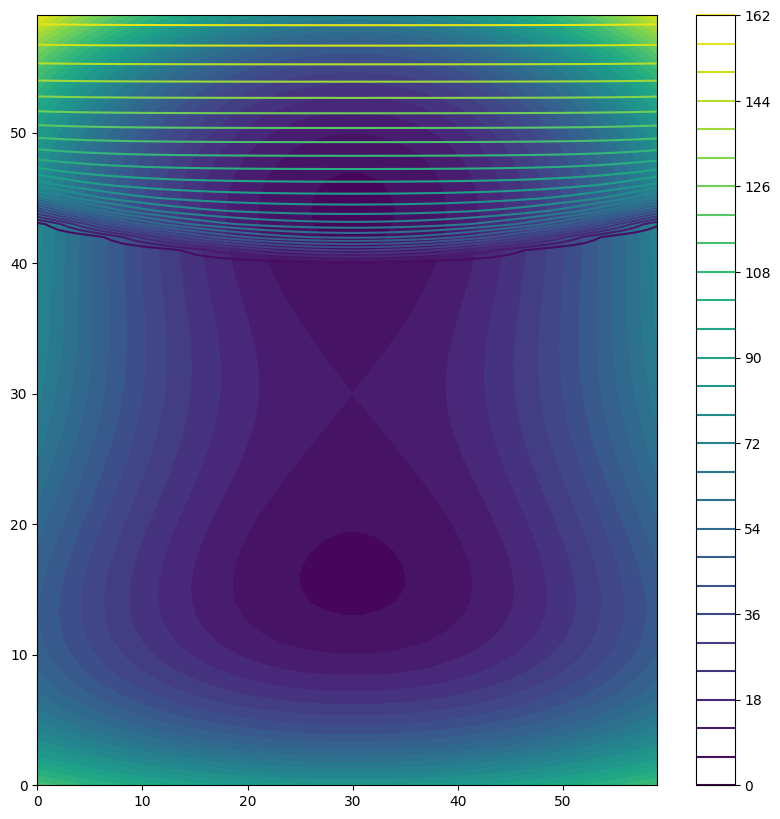

obj:  113.63932125136195 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70955D-04


 This problem is unconstrained.


obj:  113.50334776492019 [-20.11040404  -0.17563158]
obj:  113.63769288126271 [-20.13589021  -0.17564808]
obj:  113.63931980050398 [-20.13620391  -0.17564832]
obj:  113.63932121327164 [-20.13620447  -0.17564832]
obj:  113.63932124776235 [-20.1362045   -0.17564832]
obj:  113.63932125065125 [-20.1362045   -0.17564832]
obj:  113.63932125099912 [-20.13620451  -0.17564832]
obj:  113.63932125474658 [-20.13620451  -0.17564832]
obj:  113.63932125093893 [-20.13620451  -0.17564832]
obj:  113.63932125081911 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70953D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro

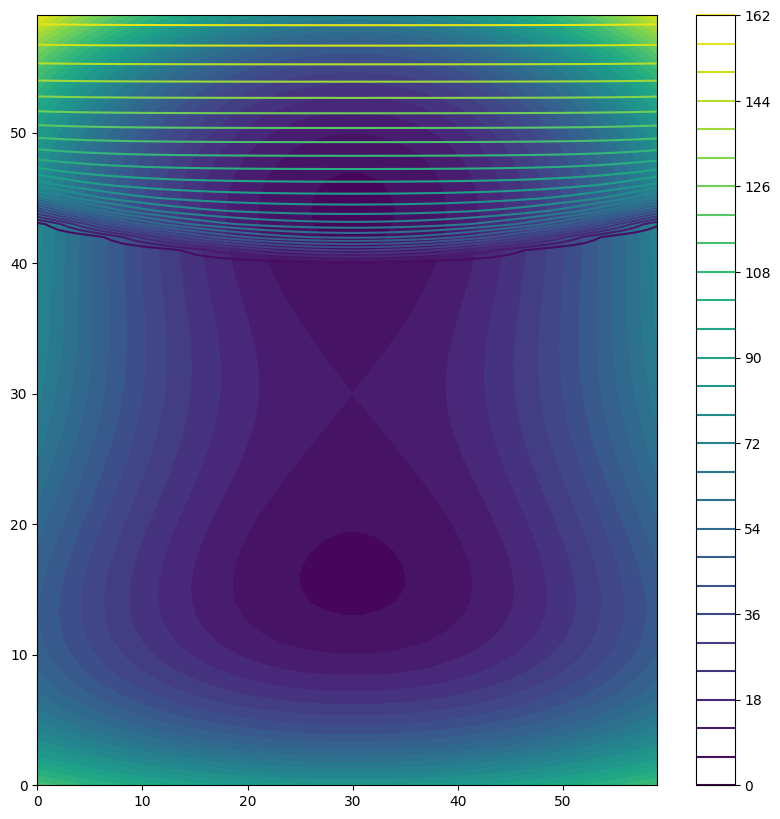

obj:  113.63932125376111 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70953D-04


 This problem is unconstrained.


obj:  113.50334781901645 [-20.11040405  -0.17563158]
obj:  113.63769288416513 [-20.13589021  -0.17564808]
obj:  113.63931979963812 [-20.13620391  -0.17564832]
obj:  113.63932121181527 [-20.13620447  -0.17564832]
obj:  113.63932124617317 [-20.1362045   -0.17564832]
obj:  113.63932124951941 [-20.1362045   -0.17564832]
obj:  113.63932125074197 [-20.13620451  -0.17564832]
obj:  113.63932125160157 [-20.13620451  -0.17564832]
obj:  113.63932124986773 [-20.13620451  -0.17564832]
obj:  113.63932125106886 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70952D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Pro


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


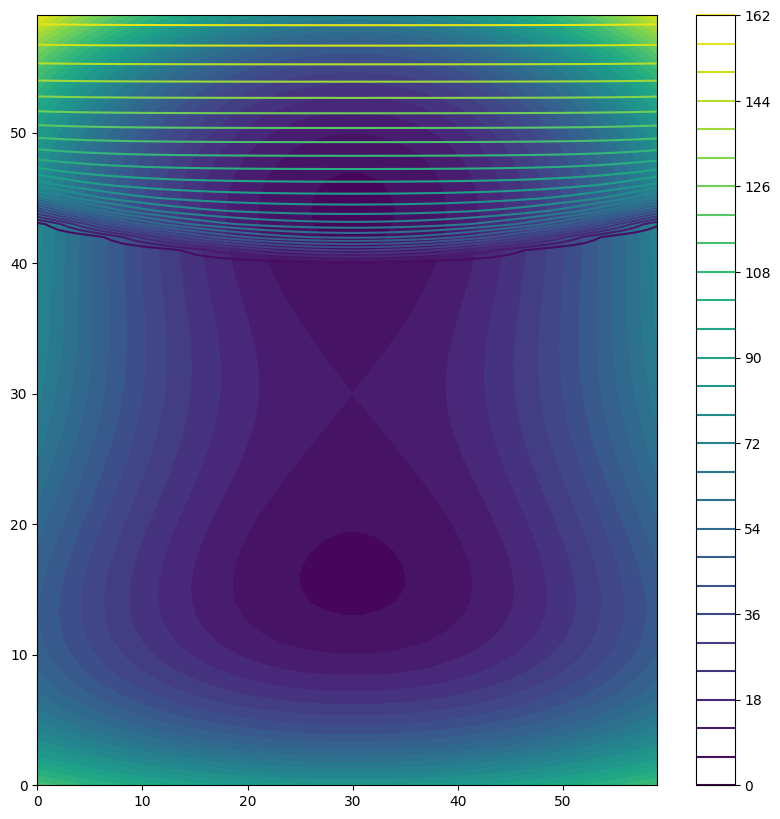

obj:  113.63932125222671 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70953D-04


 This problem is unconstrained.


obj:  113.5033478202404 [-20.11040405  -0.17563158]
obj:  113.63769288148978 [-20.13589021  -0.17564808]
obj:  113.63931979937291 [-20.13620391  -0.17564832]
obj:  113.6393212131788 [-20.13620447  -0.17564832]
obj:  113.63932124734932 [-20.1362045   -0.17564832]
obj:  113.63932125063664 [-20.1362045   -0.17564832]
obj:  113.63932125297274 [-20.13620451  -0.17564832]
obj:  113.6393212510416 [-20.13620451  -0.17564832]
obj:  113.6393212528194 [-20.13620451  -0.17564832]
obj:  113.63932125475037 [-20.13620451  -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70938D-04
obj:  113.63904048231161 [-20.1361494   -0.17564827]
obj:  113.63932112611528 [-20.13620439  -0.17564832]
obj:  113.63932123867136 [-20.13620449  -0.17564832]
obj:  113.63932124898878 [-20.1362045   -0.17564832]
obj:  113.63932125144913 [-20.13620451  -0.17564832]
obj:  113.63932125275238 [-20.13620451  -0.17564832]
obj:  113.63932125355072 [-20.13620451  -0.17564832]
obj:  113.6393212512548 [-20.13620451  -0

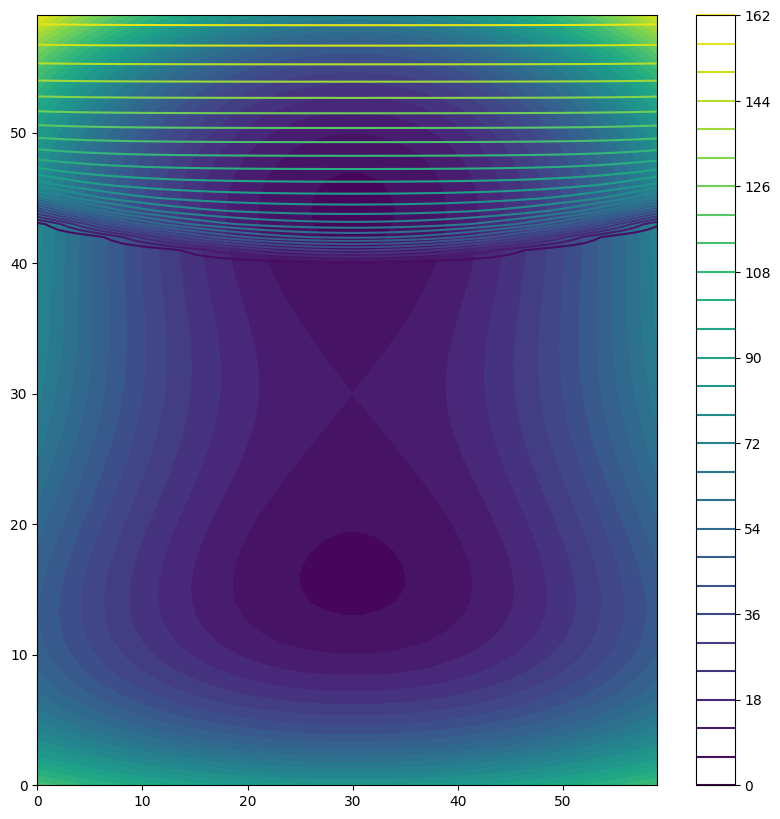

obj:  113.63932125092462 [-20.13620451  -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70938D-04


 This problem is unconstrained.


obj:  113.50334816113192 [-20.11040413  -0.17563158]
obj:  113.63769290348115 [-20.13589021  -0.17564808]
obj:  113.63931979966118 [-20.1362039   -0.17564832]
obj:  113.6393212106852 [-20.13620447  -0.17564832]
obj:  113.63932124550597 [-20.1362045   -0.17564832]
obj:  113.63932125112225 [-20.1362045   -0.17564832]
obj:  113.63932124852856 [-20.1362045   -0.17564832]
obj:  113.63932125119776 [-20.1362045   -0.17564832]
obj:  113.639321246347 [-20.1362045   -0.17564832]
obj:  113.63932125131751 [-20.1362045   -0.17564832]
obj:  113.63932125019929 [-20.1362045   -0.17564832]
obj:  113.63932124675264 [-20.1362045   -0.17564832]
obj:  113.63932125112592 [-20.1362045   -0.17564832]

At iterate    1    f= -1.13639D+02    |proj g|=  9.70741D-04
obj:  113.63903537942802 [-20.13614842  -0.17564827]
obj:  113.63932111843425 [-20.13620439  -0.17564832]
obj:  113.63932123704001 [-20.13620449  -0.17564832]
obj:  113.63932124925971 [-20.1362045   -0.17564832]
obj:  113.63932124920203 [-20.1362045   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


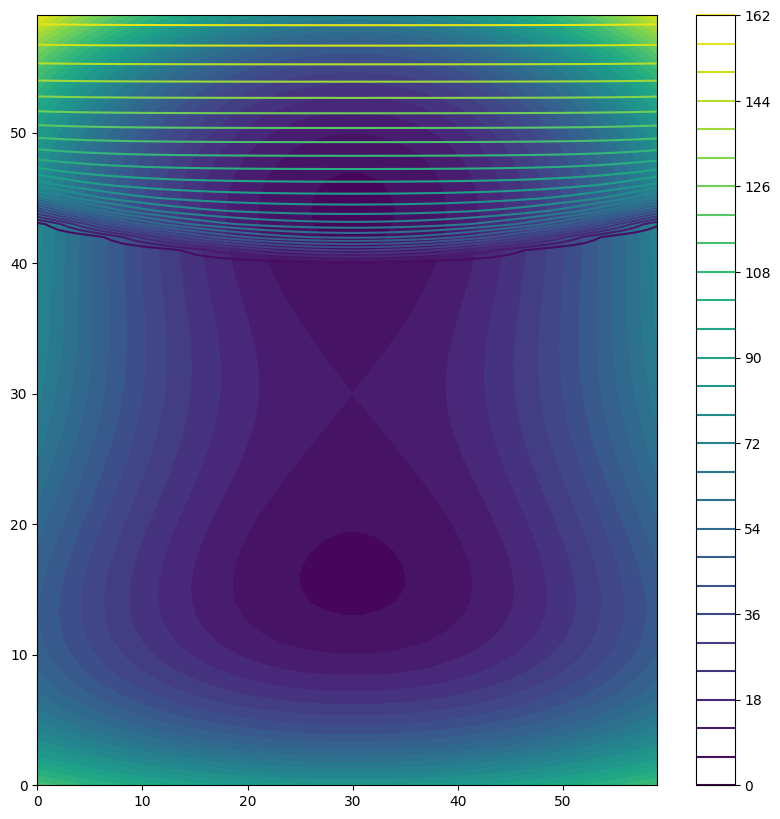

obj:  113.63932124892875 [-20.1362045   -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70736D-04


 This problem is unconstrained.


obj:  113.50335272684389 [-20.11040513  -0.17563158]
obj:  113.63769317461504 [-20.13589027  -0.17564808]
obj:  113.6393197881559 [-20.1362039   -0.17564832]
obj:  113.63932121070819 [-20.13620446  -0.17564832]
obj:  113.63932124467601 [-20.1362045   -0.17564832]
obj:  113.63932125053307 [-20.1362045   -0.17564832]
obj:  113.63932124610928 [-20.1362045   -0.17564832]
obj:  113.63932124840832 [-20.1362045   -0.17564832]
obj:  113.63932124939637 [-20.1362045   -0.17564832]
obj:  113.6393212487364 [-20.1362045   -0.17564832]
1.4570786973027023e-19 158.72139240465532
[60, 60] (60, 60)

At iterate    1    f= -1.13639D+02    |proj g|=  9.70618D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

      

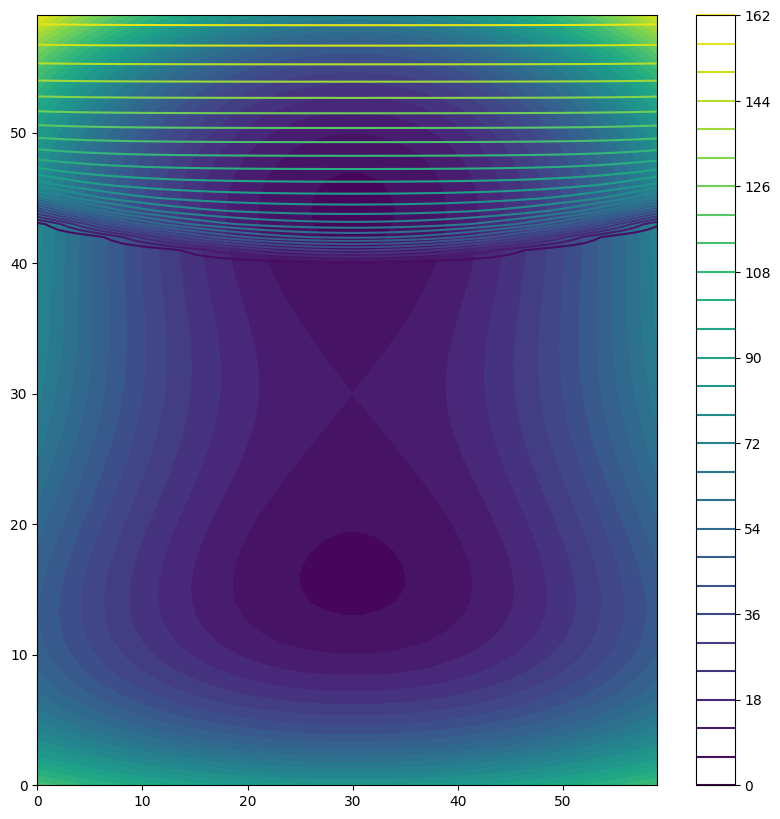

obj:  113.63932124776099 [-20.1362045   -0.17564832]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         3600     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.13639D+02    |proj g|=  9.70618D-04


 This problem is unconstrained.


obj:  113.5033554110699 [-20.11040572  -0.17563158]


KeyboardInterrupt: 

In [18]:
#this calculation can be hard to converge, presumably because of the approximate 
#eigenvalues/vectors obtained from iterative methods. Try to optimize a few times more
from IPython.core.display import display, HTML
display(HTML("<style>.jp-CodeCell.jp-mod-outputsScrolled .jp-Cell-outputArea { max-height: 88em; }</style>"))

for ikk in range(10):
    #snap=np.where(res.x > 1 , 10, 1e-8)
    plt.figure()
    z=to_mesh(np.array(VV_),ngrid)
    plt.contourf(z,levels=30)

    z=to_mesh(res.x**2,ngrid)
    #plt.contour(np.log10(z),levels=10)
    plt.contour(z,levels=30)
    plt.colorbar()
    plt.show()
    
    res = minimize(compute_obj, res.x, jac=True, method='L-BFGS-B',tol=1e-15,options={'gtol': 1e-15, 'disp': True,'maxiter':100,'eta':0.8})
    
    print(np.min(res.x**2),np.max(res.x**2))
    #res.x=np.where(res.x**2 > 220 , np.sqrt(220), res.x)
    

In [20]:
solution=res.x.copy()

#compute sharp objectives for different threshold values
for th in [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,9.9]:
    
    snap=np.where(solution > th , 1000, 0)
    ob=compute_obj(snap)
    print(th,ob[0])

obj:  91.82860749970249 [-20.15859851  -0.21715933]


/tmp/ipykernel_79489/238267159.py:115: ComplexWarning: Casting complex values to real discards the imaginary part
  grads[iseq,iw]=-2*alpha[iseq]*v[iseq,iw]**2


0.001 -91.82860749970249
obj:  98.8385597951133 [-20.14261658  -0.20175187]
0.01 -98.8385597951133
obj:  111.18905398223042 [-20.13715589  -0.17949305]
0.1 -111.18905398223042
obj:  111.1954767918859 [-20.13713     -0.17948255]
1 -111.1954767918859
obj:  111.3403042975028 [-20.13691311  -0.17924923]
2 -111.3403042975028
obj:  112.10839925220941 [-20.13675161  -0.17803056]
3 -112.10839925220941
obj:  112.10895238593194 [-20.13674884  -0.17802966]
4 -112.10895238593194
obj:  112.12843884305086 [-20.1366991   -0.17799856]
5 -112.12843884305086
obj:  112.81096833380131 [-20.1364784   -0.17692915]
6 -112.81096833380131
obj:  112.8144786924267 [-20.13646692  -0.1769236 ]
7 -112.8144786924267
obj:  113.3837512639787 [-20.13628324  -0.17604147]
8 -113.3837512639787
obj:  104.34868095274824 [-18.38197073  -0.17448696]
9 -104.34868095274824
obj:  73.79676835768844 [-12.89675324  -0.17242394]
9.9 -73.79676835768844


[60, 60] (60, 60)
[60, 60] (60, 60)


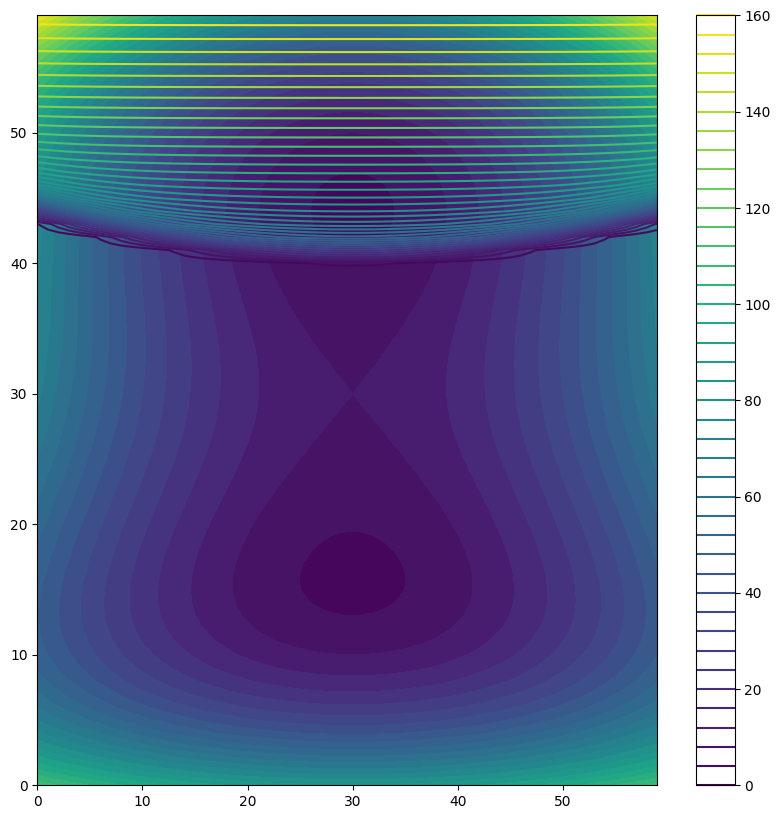

(1.4570786973027023e-19, 158.72139240465532)

In [24]:


#plot the results
z=to_mesh(np.array(VV_),ngrid)
plt.contourf(z,levels=30)

z=to_mesh(res.x**2,ngrid)
#plt.contour(np.log10(z),levels=30)
plt.contour(z,levels=50)
plt.colorbar()
plt.show()

np.min(z),np.max(z)